# COMP9517 Ass1 Task2
+ Here Gaussian pyramid is used to speed up the alignment
+ Some methods in Task1 will be reused

## 0. Adjustment
+ 3 level images(including original image): efficiency
+ Choose suitable ROI: efficiency
+ The size of window and step can be scaled based on the size of image: efficiency
+ Normalization: accuracy
+ Sharpen the image with lowest resolution: accuracy

In [1]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from PIL import Image, ImageEnhance
import time
import task1loop
import task1matrix

## 1. Helper function: sharpen
+ For low-resolution images, we can sharpen them to make match more accurate

In [2]:
def sharpen(img, sharpen_factor):
    img_pil = Image.fromarray(img)
    img_enhanced = ImageEnhance.Sharpness(img_pil).enhance(sharpen_factor)
    img_cv = np.array(img_enhanced, dtype = np.uint8)
    return img_cv

## 2. Look for best match in higher resolution
+ For images with lowest resolution, we reuse the method in task1
+ When we get best match from low-resolution image, we map it to higher resolution
+ The new start position [h_new1, w_new1, h_new2, w_new2] = 2 * [h_old1, w_old1, h_old2, w_old2]
+ Instead of sliding window, we just need to check this position as well as 8 positions around it: [h_new1 +- step, w_new1 +- step, h_new2 +- step, w_new2 +- step]

In [3]:
# Map low-resolution to high-resolution, and rechoose best match
# img1 and img2: images in single channel
# h_new1, w_new1, h_new2, w_new2 = 2 * [h_old1, w_old1, h_old2, w_old2]
# window: the size of window, default 40
# step: step length, default 1
def get_best_match_new_resolution(img1, img2, h_new1, w_new1, h_new2, w_new2, window, step):
    
    # rescale the parameters
    height, width = img1.shape
    scale_factor = max(int(min(height / 350, width / 400)), 1)
    window *= scale_factor
    step *= scale_factor
    
    # init the result
    window1 = img1[h_new1 : h_new1+window, w_new1 : w_new1+window]
    window2 = img2[h_new2 : h_new2+window, w_new2 : w_new2+window]
    img1_h_best, img1_w_best, img2_h_best, img2_w_best = h_new1, w_new1, h_new2, w_new2
    best_match = task1loop.ssd(window1, window2)
    
    # generate other candidates
    candidates = [[h_new1-step, w_new1-step, h_new2-step, w_new2-step], \
                  [h_new1-step, w_new1, h_new2-step, w_new2], \
                  [h_new1-step, w_new1+step, h_new2-step, w_new2+step], \
                  [h_new1, w_new1-step, h_new2, w_new2-step], \
                  [h_new1, w_new1+step, h_new2, w_new2+step], \
                  [h_new1+step, w_new1-step, h_new2+step, w_new2-step], \
                  [h_new1+step, w_new1, h_new2+step, w_new2], \
                  [h_new1+step, w_new1+step, h_new2+step, w_new2+step]]

    for items in candidates[:]:
        h_candidate1, w_candidate1, h_candidate2, w_candidate2 = items
        if h_candidate1 < 0 or h_candidate1+window >= height or h_candidate2 < 0 or h_candidate2+window >= height:
            continue
        if w_candidate1 < 0 or w_candidate1+window >= width or w_candidate2 < 0 or w_candidate2+window >= width:
            continue
        window1 = img1[h_candidate1:h_candidate1+window, w_candidate1:w_candidate1+window]
        window2 = img2[h_candidate2:h_candidate2+window, w_candidate2:w_candidate2+window]
        curr_match = task1loop.ssd(window1, window2)
        if curr_match < best_match:
            best_match = curr_match
            img1_h_best, img1_w_best, img2_h_best, img2_w_best = h_candidate1, w_candidate1, h_candidate2, w_candidate2
    
    return img1_h_best, img1_w_best, img2_h_best, img2_w_best, best_match

In [4]:
# Combined methods
def get_best_match_pyramid(img1, img2, sharpen_factor, h_factor, w_factor, window, threshold, step):
    
    # Generate Gaussian pyramid, level 0 is [img1, img2]
    # level 1
    img1_down1 = cv2.pyrDown(img1)
    img2_down1 = cv2.pyrDown(img2)
    
    # level 2
    img1_down2 = cv2.pyrDown(img1_down1)
    img2_down2 = cv2.pyrDown(img2_down1)
    
    # sharpen the smallest images, then find best match
    img1_down2 = sharpen(img1_down2, sharpen_factor)
    img2_down2 = sharpen(img2_down2, sharpen_factor)
    
    # get roi
    img1_down2_roi = task1loop.get_roi(img1_down2, h_factor, w_factor, window, threshold, step)
    img2_down2_roi = task1loop.get_roi(img2_down2, h_factor, w_factor, window, threshold, step)
    
    # get best match of level2
    h1, w1, h2, w2, best_match = task1loop.get_best_match(img1_down2_roi, img2_down2_roi, window, step)
    
    # get best match of level1
    h1, w1, h2, w2, best_match = get_best_match_new_resolution(img1_down1, img2_down1, h1*2, w1*2, h2*2, w2*2, window, step)
    
    # get best match of level0
    h1, w1, h2, w2, best_match = get_best_match_new_resolution(img1, img2, h1*2, w1*2, h2*2, w2*2, window, step)
    
    return h1, w1, h2, w2, best_match

## 3. Main function

In [5]:
# Main function
#   sharpen_factor = 20
#   h_factor = wfactor = 0 (low-resolution image is small)
#   window = 40
#   threshold = 15
#   step = 1
def task2(img_name, sharpen_factor, h_factor, w_factor, window, threshold, step):
    
    start_time = time.clock()
    
    # read and split the image
    img = cv2.imread(img_name)
    sub_height = int(img.shape[0] / 3)
    blue = img[0:sub_height,:,0]
    green = img[sub_height:sub_height*2,:,1]
    red = img[sub_height*2:sub_height*3,:,2]
    
    # normalization
    normalized_blue = cv2.normalize(blue, 0, 1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    normalized_green = cv2.normalize(green, 0, 1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    normalized_red = cv2.normalize(red, 0, 1,norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    
    # blue and green
    rows, cols = blue.shape
    b_h, b_w, g_h, g_w, best_match = get_best_match_pyramid(blue, green, sharpen_factor, h_factor, w_factor, window, threshold, step)    
    print "Best match for blue and green : " + str([b_h, b_w, g_h, g_w])
    changed_green = cv2.warpAffine(green, np.float32([[1,0,b_w-g_w],[0,1,b_h-g_h]]), (cols, rows))
    
    # blue and red
    b_h, b_w, r_h, r_w, best_match = get_best_match_pyramid(blue, red, sharpen_factor, h_factor, w_factor, window, threshold, step)
    print "Best match for blue and red : " + str([b_h, b_w, r_h, r_w])
    changed_red = cv2.warpAffine(red, np.float32([[1,0,b_w-r_w],[0,1,b_h-r_h]]), (cols, rows))
    
    # merge the images
    merged_img = cv2.merge([blue, changed_green, changed_red])
    
    end_time = time.clock()
    print "Running time : " + str(end_time-start_time)
    
    return merged_img

## Test

In [16]:
merged_img1 = task2("s1.jpg", 20, 0, 0, 45, 10, 1)
merged_img2 = task2("s2.jpg", 20, 0, 0, 30, 15, 1)
merged_img3 = task2("s3.jpg", 20, 0, 0, 20, 15, 1)
merged_img4 = task2("s4.jpg", 20, 0, 0, 40, 10, 1)
merged_img5 = task2("s5.jpg", 20, 0.5, 0.5, 50, 10, 1)

Best match for blue and green : [39, 0, 35, 0]
Best match for blue and red : [27, 4, 19, 0]
Running time : 0.617789
Best match for blue and green : [58, 4, 54, 0]
Best match for blue and red : [59, 11, 47, 3]
Running time : 2.168023
Best match for blue and green : [10, 0, 6, 0]
Best match for blue and red : [14, 0, 2, 0]
Running time : 1.781154
Best match for blue and green : [37, 0, 37, 0]
Best match for blue and red : [37, 4, 29, 0]
Running time : 0.584921
Best match for blue and green : [3, 2, 3, 2]
Best match for blue and red : [3, 0, 3, 0]
Running time : 0.038848


In [17]:
merged_img1 = cv2.cvtColor(merged_img1, cv2.COLOR_BGR2RGB)
merged_img2 = cv2.cvtColor(merged_img2, cv2.COLOR_BGR2RGB)
merged_img3 = cv2.cvtColor(merged_img3, cv2.COLOR_BGR2RGB)
merged_img4 = cv2.cvtColor(merged_img4, cv2.COLOR_BGR2RGB)
merged_img5 = cv2.cvtColor(merged_img5, cv2.COLOR_BGR2RGB)

In [18]:
plt.figure(figsize=(6, 30))
plt.subplot(511)
plt.imshow(merged_img1)
plt.subplot(512)
plt.imshow(merged_img2)
plt.subplot(513)
plt.imshow(merged_img3)
plt.subplot(514)
plt.imshow(merged_img4)
plt.subplot(515)
plt.imshow(merged_img5)

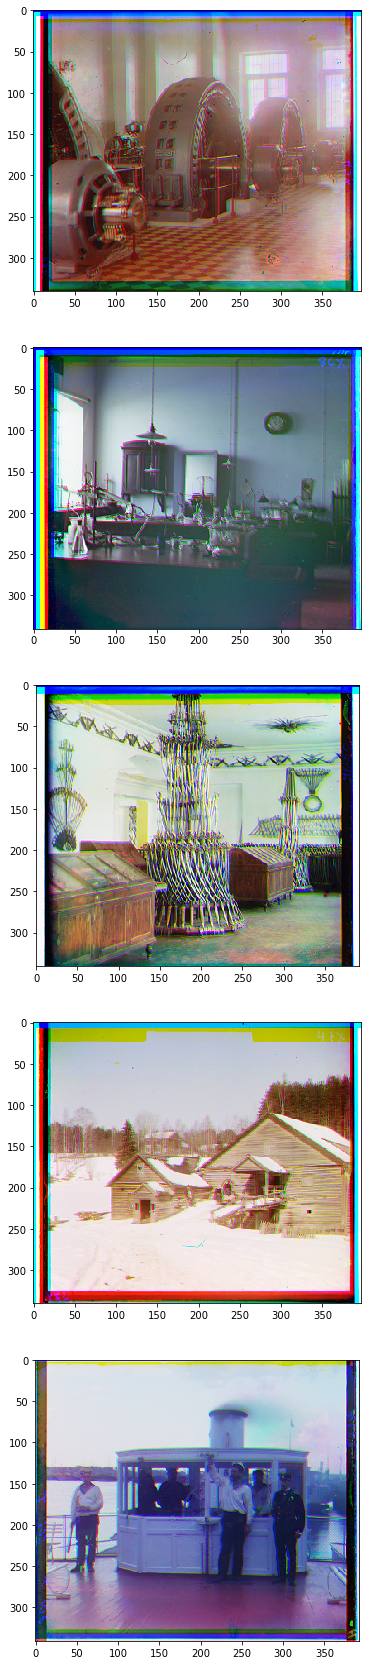

In [19]:
plt.show()